0.0039215686274509665 0.996078431372549 0.114118647195049


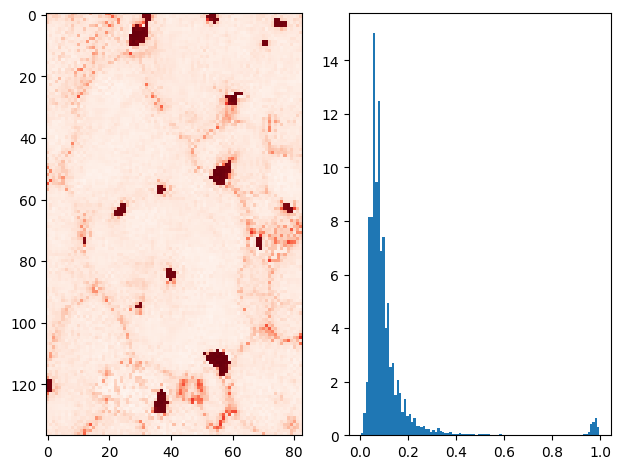

In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import copy
import pandas as pd
import dionysus as d
import networkx
from tqdm.auto import tqdm
from scipy import stats

# im_test = np.array(Image.open("../figures/GND15pct_rotated.jpg").convert("RGB"))
# im_gray = 1-np.array(Image.open("../figures/GND0pct_rotated.jpg").convert("L").resize((100,100))).astype(int)/255
im_gray = 1-np.array(Image.open("../figures/Small_5pct.png").convert("L")).astype(int)/255
# im_gray = 1-np.array(Image.open("../figures/GND0pct_rotated.jpg").convert("L")).astype(int)/255
# im_norm = im_test.astype(int)/255
print(np.min(im_gray), np.max(im_gray), np.mean(im_gray.flatten()))
fig, ax = plt.subplots(1,2)
ax[0].imshow(im_gray, cmap="Reds")
ax[1].hist(im_gray.flatten(), bins=100, density=True)
fig.tight_layout()
plt.show()

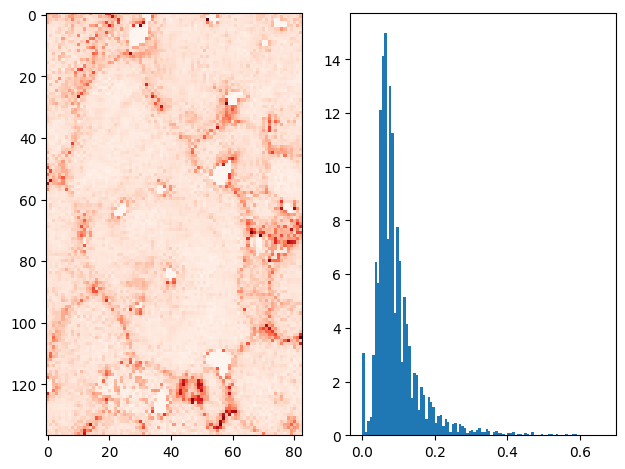

In [2]:
im_red = copy.deepcopy(im_gray)
im_red[im_red > 0.8] = 0
fig, ax = plt.subplots(1,2)
ax[0].imshow(im_red, cmap="Reds")
ax[1].hist(im_red.flatten(), bins=100, density=True)
fig.tight_layout()
plt.show()

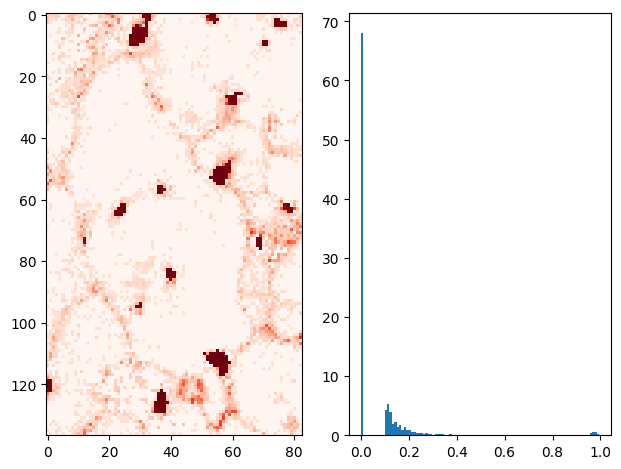

In [3]:
im_grain = copy.deepcopy(im_gray)
im_grain[im_grain < 0.10] = 0
fig, ax = plt.subplots(1,2)
ax[0].imshow(im_grain, cmap="Reds")
ax[1].hist(im_grain.flatten(), bins=100, density=True)
fig.tight_layout()
plt.show()

Amount of points: 2775


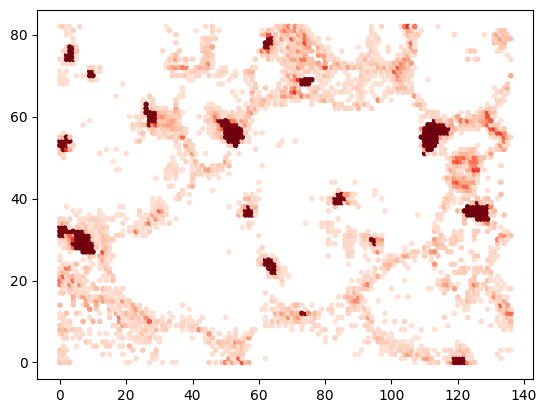

In [4]:
X = np.vstack(np.where(im_gray>np.mean(im_gray))).T
y = np.array([im_gray[X[i,0], X[i,1]] for i in range(X.shape[0])])
print("Amount of points:", len(y))
plt.scatter(X[:,0], X[:,1], marker=".", c=y, cmap="Reds", vmin=0, vmax=1)

In [5]:
from sklearn.datasets import make_circles
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN

from tdamapper.learn import MapperAlgorithm
from tdamapper.cover import CubicalCover
from tdamapper.plot import MapperPlot

# load a labelled dataset
# X, labels = make_circles(n_samples=5000, noise=0.05, factor=0.3, random_state=42)
# y = X[:,1]

cover = CubicalCover(n_intervals=15, overlap_frac=0.3, algorithm="standard")
clust = DBSCAN(eps=5)
graph = MapperAlgorithm(cover, clust).fit_transform(X, X)
print("Mapper done!")

# color according to labels
fig, node_col = MapperPlot(graph, dim=3, seed=42, iterations=60, layout_engine="networkx").plot_plotly(colors=y, cmap="Reds")
fig.show(config={'scrollZoom': True})


Mapper done!
Node_col:
 {183: 0.1606060606060606, 182: 0.16629570747217803, 181: 0.19968203497615264, 180: 0.2080961416824794, 179: 0.3629084967320262, 178: 0.633769063180828, 177: 0.37145462836297305, 176: 0.5649019607843135, 175: 0.575294117647059, 174: 0.2782608695652174, 173: 0.4587175410704821, 172: 0.3172549019607843, 170: 0.17920380273321448, 171: 0.14602076124567476, 169: 0.19484004127966972, 168: 0.16479925303454715, 167: 0.3070588235294117, 166: 0.3794302626711062, 165: 0.15294117647058822, 163: 0.4772549019607844, 164: 0.4009049773755657, 162: 0.12313725490196081, 158: 0.18120915032679738, 157: 0.19529411764705876, 156: 0.1431372549019608, 155: 0.15627450980392155, 154: 0.16746880570409986, 159: 0.15058823529411763, 150: 0.5655228758169936, 151: 0.4388795518207283, 148: 0.17161531279178338, 149: 0.14681372549019608, 147: 0.18575851393188855, 146: 0.186171310629515, 144: 0.33725490196078434, 143: 0.40425531914893614, 145: 0.14313725490196078, 142: 0.14066496163682865, 139: 0.

In [6]:
# plt.scatter(X[:,0], X[:,1], marker=".", c=y, cmap="Reds", vmin=0, vmax=1)
# plt.scatter(X[graph.nodes[51]["ids"],0], X[graph.nodes[51]["ids"],1], marker="o", c="y", alpha=0.5)
# plt.scatter(X[graph.nodes[47]["ids"],0], X[graph.nodes[47]["ids"],1], marker="o", c="g", alpha=0.5)
# plt.scatter(X[graph.nodes[79]["ids"],0], X[graph.nodes[79]["ids"],1], marker="o", c="b", alpha=0.5)
# plt.scatter(X[graph.nodes[12]["ids"],0], X[graph.nodes[12]["ids"],1], marker="o", c="black", alpha=0.5)


Amoung of simplices: 933, 
0D: 163 		 1D: 395 
2D: 303 		 3D: 72.


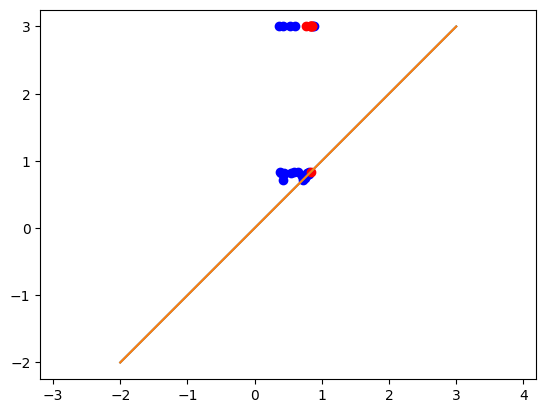

In [7]:
fig, ax = plt.subplots(1,1)
simplices = []
for c in networkx.enumerate_all_cliques(graph):
    # if len(c) <= 2:
    simplices.append((c, np.max([1-node_col[i] for i in c])))
    # else:
    #     simplices.append((c, np.sum([1-y[i] for i in c])))

print(f"Amoung of simplices: {len(simplices)}, \n"
        f"0D: {len([c for c in simplices if len(c[0]) == 1])} \t\t 1D: {len([c for c in simplices if len(c[0]) == 2])} \n"
        f"2D: {len([c for c in simplices if len(c[0]) == 3])} \t\t 3D: {len([c for c in simplices if len(c[0]) == 4])}.")
f = d.Filtration()
for vertices, time in simplices:
    f.append(d.Simplex(vertices, time))
f.sort()
p = d.cohomology_persistence(f, 47, True)
dgms = d.init_diagrams(p, f)
d.plot.plot_all_diagrams(dgms, ax=ax)

In [8]:
cocycles = []
birth_deaths = []
for point in dgms[1]:
    if point.death-point.birth >0:
        birth_deaths.append((point.birth, point.death))
        cocycles.append(p.cocycle(point.data))
len(cocycles)

8

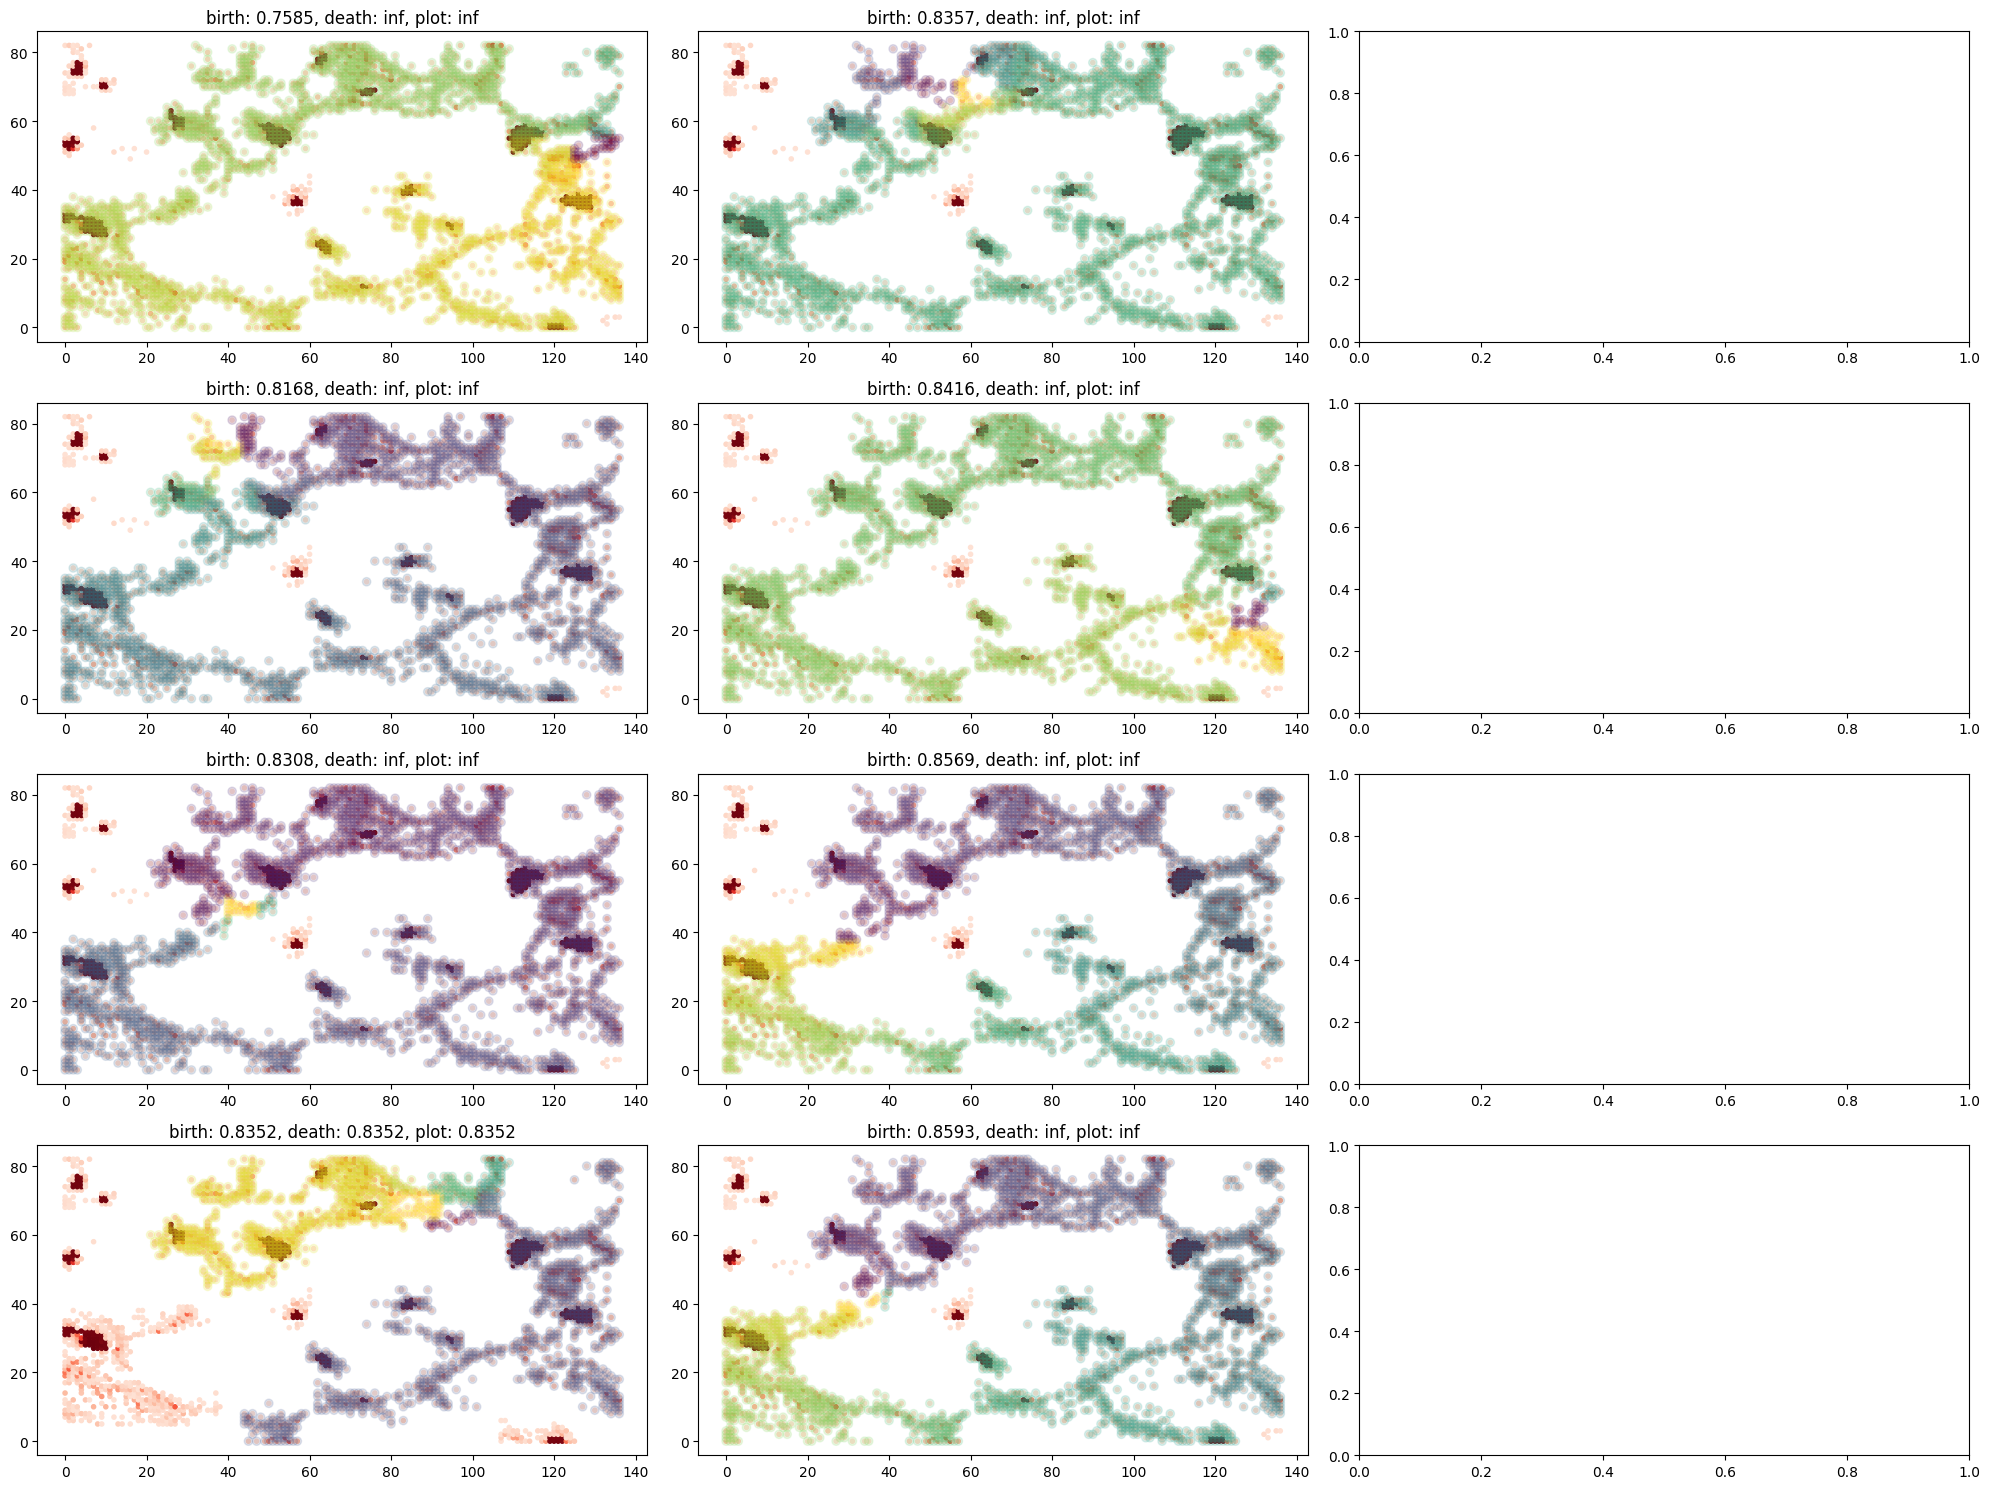

In [9]:
point_i = 1

fig, axs = plt.subplots(4, 3)
fig.set_size_inches(20,15)
vertex_values_list = []
used_nodes_list = []
for point_i in range(min(len(cocycles), 12)):
    point_birth = birth_deaths[point_i][0]
    point_death = birth_deaths[point_i][1]
    plot_time = point_birth+(point_death-point_birth)/100
    f_restricted = d.Filtration([s for s in f if s.data < plot_time])
    
    used_vertex_ids = []
    used_nodes_ids = []
    for s in f_restricted:
        if s.dimension() == 0:
            used_vertex_ids += graph.nodes[s[0]]["ids"]
            used_nodes_ids.append(s[0])
    used_vertex_ids = np.array(list(set(used_vertex_ids)))
    used_nodes_list.append(used_nodes_ids)
    X_restricted = X[used_vertex_ids, :]

    vertex_values = d.smooth(f_restricted, cocycles[point_i], 47)
    vertex_values_list.append(vertex_values)
    point_values = np.zeros(X.shape[0])
    point_values_i = np.zeros(X.shape[0])
    for s in f_restricted:
        if s.dimension() == 0:
            node = s[0]
        else:
            continue
        for point_id in graph.nodes[node]["ids"]:
            try:
                point_values[point_id] = vertex_values[int(node)]
            except:
                print(node, point_id)
                raise IndexError
            point_values_i[point_id] += 1
    point_values =np.array(point_values)[used_vertex_ids]
    # point_values = np.array([point_values[i]/max(point_values_i[i], 1) for i in range(len(point_values))])
    axs[point_i%4, point_i//4].scatter(X_restricted[:,0], X_restricted[:,1], c=y[used_vertex_ids],  cmap="Reds", vmin=0, vmax=1, marker=".")
    axs[point_i%4, point_i//4].scatter(X_restricted[point_values!=0,0], X_restricted[point_values!=0,1], c=point_values[point_values!=0], alpha=0.15, marker="o")
    axs[point_i%4, point_i//4].set_title(f"birth: {point_birth :.4f}, death: {point_death :.4f}, plot: {plot_time:.4f}")
fig.tight_layout()

In [10]:
selected_plot = 0

graph_restricted = graph.copy()
graph_restricted.remove_nodes_from([n for n in graph.nodes if n not in used_nodes_list[selected_plot]])

fig = MapperPlot(graph_restricted, dim=3, seed=42, iterations=60, layout_engine="networkx").plot_plotly_node_col(node_colors={int(node): vertex_values_list[selected_plot][int(node)] for node in graph_restricted.nodes}, cmap="viridis")
fig.show(config={'scrollZoom': True})

In [ ]:
from Laplacian_Functions import *

def id_fun(x):
    return 1

eigenvalues, relevant_times, fig, ax = plot_Laplacian_eigenvalues(f, lambda x: 1, plot_types="all", plot_args_diag={"c": "black", "alpha": 1, "marker": "x"}, laplacian_type="cross", plot_type_to_fun={"Amount of": len})


NameError: name 'f' is not defined

(<Figure size 2400x800 with 36 Axes>,
 array([[<Axes: title={'center': 'Min eigenvalue'}, ylabel='q=0'>,
         <Axes: title={'center': 'Max eigenvalue'}>,
         <Axes: title={'center': 'Sum eigenvalue'}>,
         <Axes: title={'center': 'Mean eigenvalue'}>,
         <Axes: title={'center': 'Gmean eigenvalue'}>,
         <Axes: title={'center': 'Log Prod eigenvalue'}>],
        [<Axes: ylabel='q=1'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >]], dtype=object))

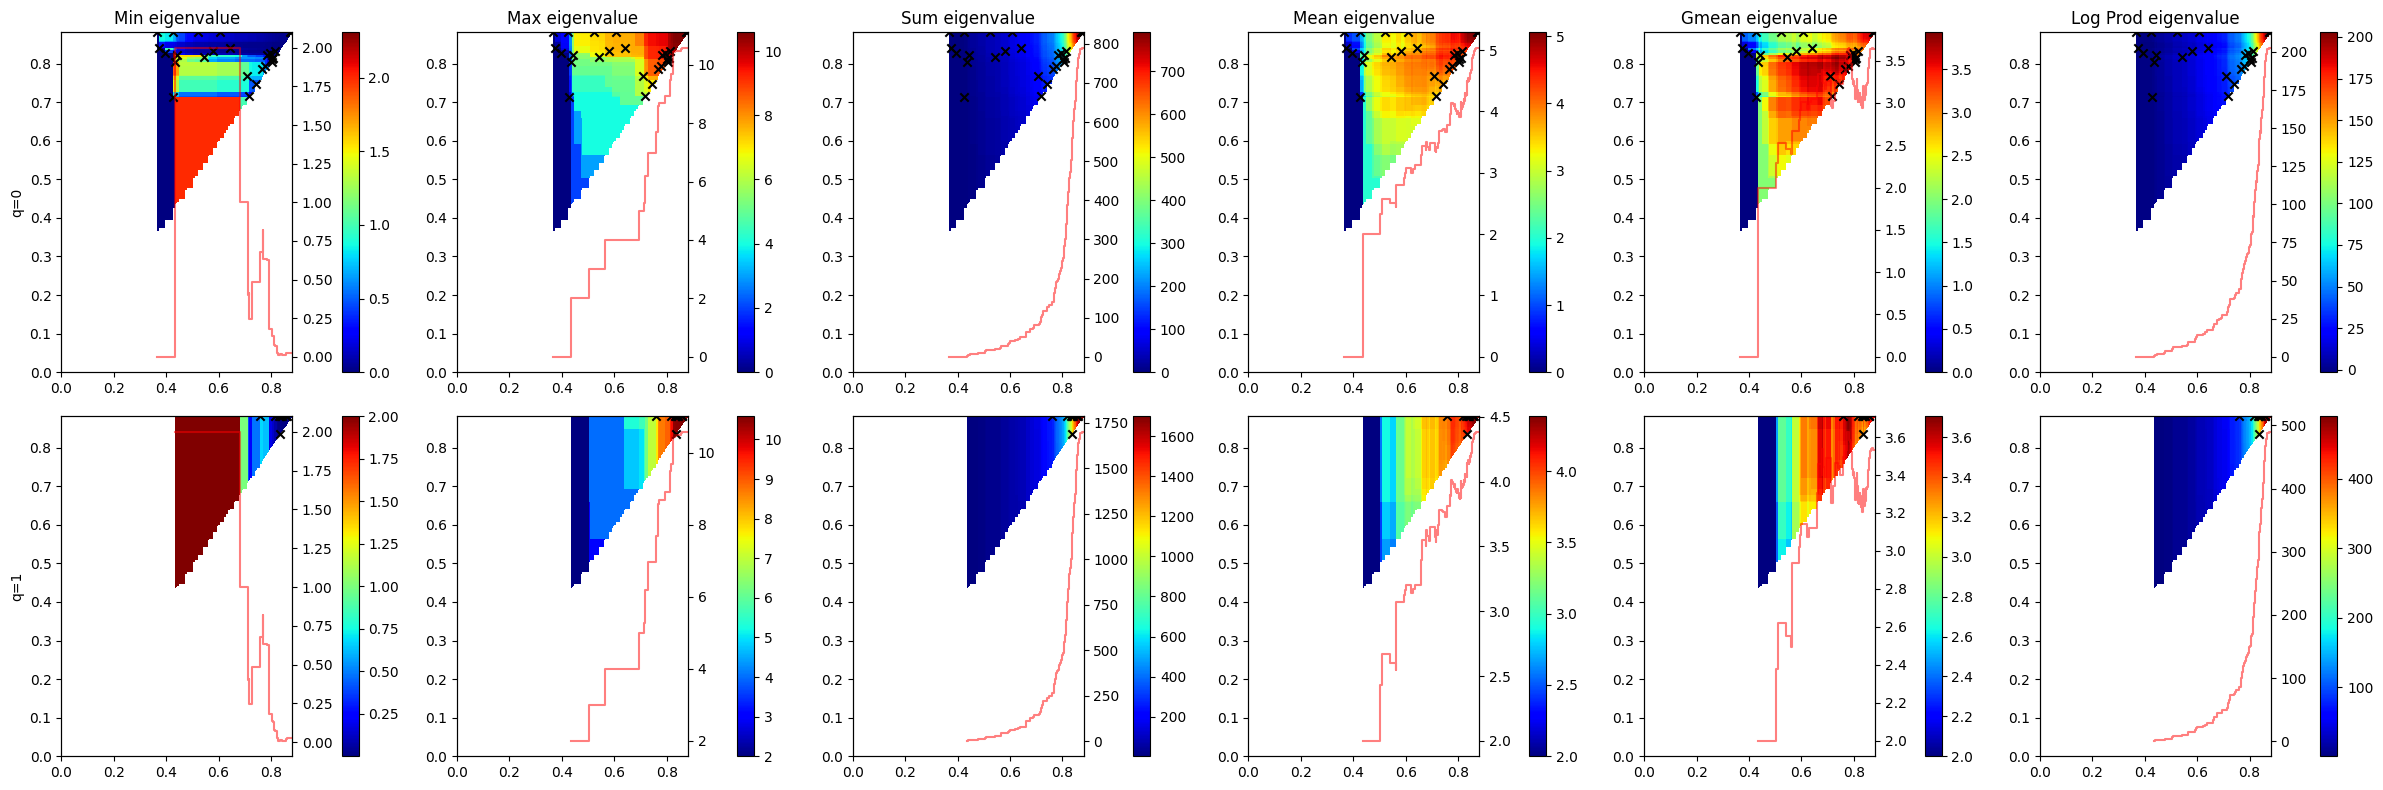

In [12]:
p = d.cohomology_persistence(f, 47, True)
dgms = d.init_diagrams(p, f)
barcodes = [[(p.birth, p.death) for p in dgms[q]] for q in range(len(dgms))]
plot_eigenvalues(eigenvalues, relevant_times, plot_types=["Min", "Max", "Sum", "Mean", "Gmean", "Log Prod"], barcodes=barcodes, plot_args_diag={"c": "black", "alpha": 1, "marker": "x"}, plot_type_to_fun={"Log Prod": lambda x: np.sum(np.log(x))})

(array([ 4.,  7., 11., 12., 16., 16., 15., 12.,  7.,  6.,  8.,  1.,  1.,
         3.,  1.,  5.,  3.,  0.,  2.,  3.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  3.,  0.,  1.,  2.,  0.,  2.,  0.,  1.,  0.,  2.,  0.,  0.,
         2.,  0.,  0.,  3.,  2.,  2.,  0.,  0.,  1.,  0.,  2.]),
 array([0.12313725, 0.13334989, 0.14356253, 0.15377516, 0.1639878 ,
        0.17420044, 0.18441307, 0.19462571, 0.20483834, 0.21505098,
        0.22526362, 0.23547625, 0.24568889, 0.25590153, 0.26611416,
        0.2763268 , 0.28653943, 0.29675207, 0.30696471, 0.31717734,
        0.32738998, 0.33760261, 0.34781525, 0.35802789, 0.36824052,
        0.37845316, 0.3886658 , 0.39887843, 0.40909107, 0.4193037 ,
        0.42951634, 0.43972898, 0.44994161, 0.46015425, 0.47036688,
        0.48057952, 0.49079216, 0.50100479, 0.51121743, 0.52143007,
        0.5316427 , 0.54185534, 0.55206797, 0.56228061, 0.57249325,
        0.58270588, 0.59291852, 0.60313115, 0.61334379, 0.62355643,
        0.63376906]),
 <BarContainer

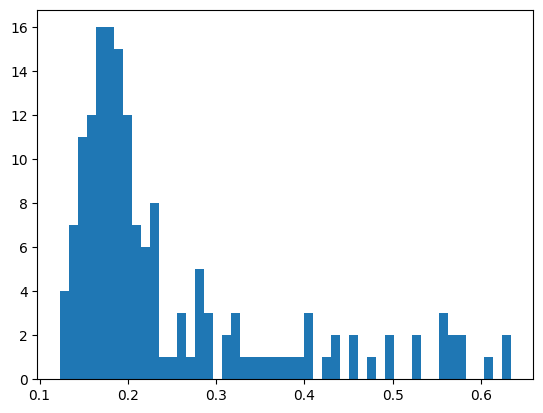

In [12]:
plt.hist([node_col[i] for i in node_col.keys()], bins=50)

In [13]:
def weight_fun(x):
    nodes = x.split(",")
    weight = 1
    for node in nodes:
        if node_col[int(node)] > 0.5:
            weight *= 2
    return weight**len(nodes)

eigenvalues_weighted, relevant_times_weighted = persistent_Laplacian_eigenvalues(f, weight_fun)

  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

(<Figure size 2400x800 with 36 Axes>,
 array([[<Axes: title={'center': 'Min eigenvalue'}, ylabel='q=0'>,
         <Axes: title={'center': 'Max eigenvalue'}>,
         <Axes: title={'center': 'Sum eigenvalue'}>,
         <Axes: title={'center': 'Mean eigenvalue'}>,
         <Axes: title={'center': 'Gmean eigenvalue'}>,
         <Axes: title={'center': 'Log Prod eigenvalue'}>],
        [<Axes: ylabel='q=1'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >]], dtype=object))

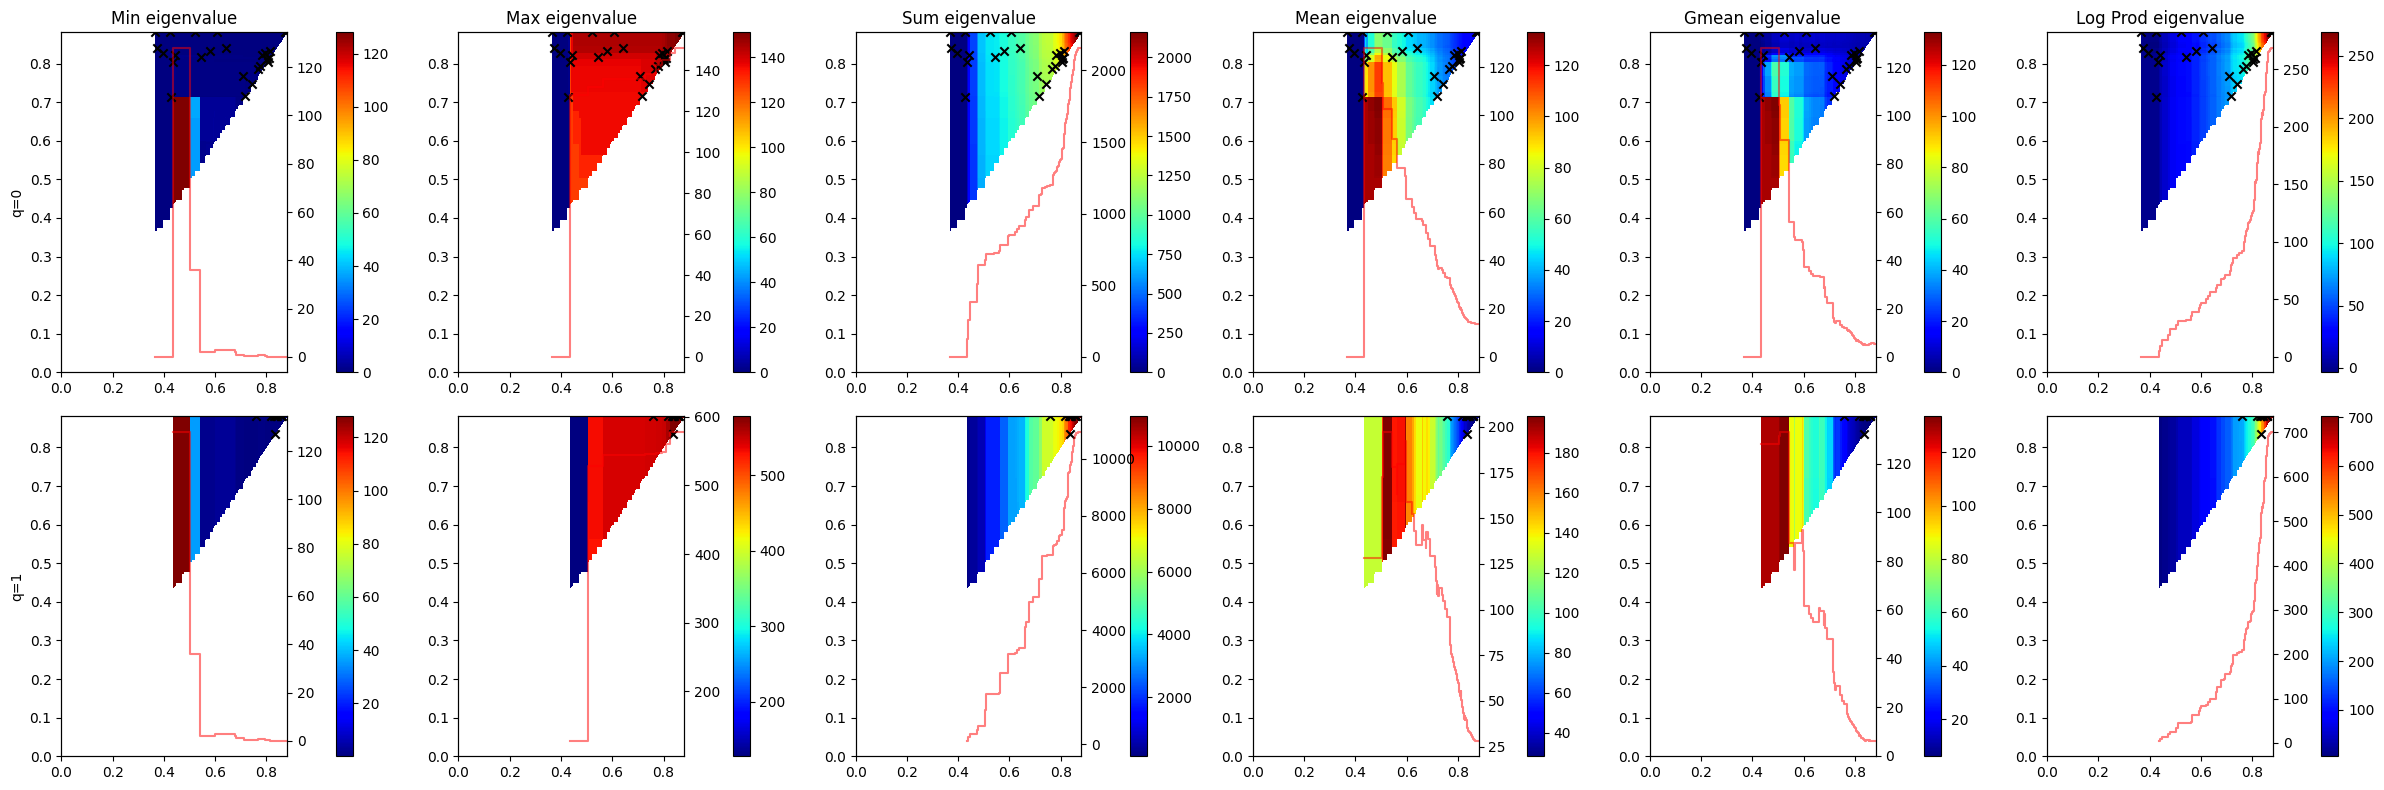

In [17]:
p = d.cohomology_persistence(f, 47, True)
dgms = d.init_diagrams(p, f)
barcodes = [[(p.birth, p.death) for p in dgms[q]] for q in range(len(dgms))]
plot_eigenvalues(eigenvalues_weighted, relevant_times_weighted, plot_types=["Min", "Max", "Sum", "Mean", "Gmean", "Log Prod"], barcodes=barcodes, plot_args_diag={"c": "black", "alpha": 1, "marker": "x"}, plot_type_to_fun={"Log Prod": lambda x: np.sum(np.log(x))})

In [29]:
weighted_barcodes_df = barcodes_df[["q", "birth", "death", "multiplicity"]]
weighted_barcodes_df.insert(4, "value", barcodes_df["p_ij"]/(barcodes_df["p_im1jm1"]))
weighted_barcodes_df.insert(5, "weight", ((weight_barcodes_df.loc[:, "p_ij"]/(weight_barcodes_df.loc[:, "p_im1jm1"])) / (weighted_barcodes_df["value"])).pow(0.5))
weighted_barcodes_df = weighted_barcodes_df.apply(lambda x: x.apply(lambda y: np.round(y, 4) if y is not None else None).apply(lambda y: np.sort(y) if type(y) == np.ndarray else y), axis=1).groupby("q").apply(display, include_groups=False)
weighted_barcodes_df

birth                                           death  \
0   0.4259+0.0000j  7.135000e-01+0.000000e+                    00j   
1   0.7170+0.0000j  7.171000e-01+0.000000e+                    00j   
2   0.7423+0.0000j  7.481000e-01+0.000000e+                    00j   
3   0.7081+0.0000j  7.678000e-01+0.000000e+                    00j   
4   0.7656+0.0000j  7.853000e-01+0.000000e+                    00j   
5   0.7767+0.0000j  7.940000e-01+0.000000e+                    00j   
6   0.4345+0.0000j  8.051000e-01+0.000000e+                    00j   
7   0.8047+0.0000j  8.052000e-01+0.000000e+                    00j   
8   0.8029+0.0000j  8.127000e-01+0.000000e+                    00j   
9   0.8093+0.0000j  8.152000e-01+0.000000e+                    00j   
10  0.5434+0.0000j  8.160000e-01+0.000000e+                    00j   
11  0.7833+0.0000j  8.219000e-01+0.000000e+                    00j   
12  0.4422+0.0000j  8.229000e-01+0.000000e+                    00j   
13  0.3950+0.0000j  8.263000e-01+0.000000e+                    00j   
14  0.7951+0.0000j  8.269000e-01+0.000000e+                    00j   
15  0.8138+0.0000j  8.325000e-01+0.000000e+                    00j   
16  0.5804+0.0000j  8.326000e-01+0.000000e+                    00j   
17  0.6420+0.0000j  8.395000e-01+0.000000e+                    00j   
18  0.3734+0.0000j  8.401000e-01+0.000000e+                    00j   
19  0.3662+0.0000j           inf+0.000000e+                    00j   
20  0.4247+0.0000j           inf+0.000000e+                    00j   
21  0.5227+0.0000j           inf+0.000000e+                    00j   
22  0.6071+0.0000j           inf+0.000000e+                    00j   
23  0.8722+0.0000j           inf+0.000000e+                    00j   

    multiplicity           value    weight  
0       1.0+0.0j  0.6957+0.0000j  1.0+0.0j  
1       1.0+0.0j  1.1250+0.0000j  1.0+0.0j  
2       1.0+0.0j  1.5000+0.0000j  1.0+0.0j  
3       1.0+0.0j  1.9200+0.0000j  1.0+0.0j  
4       1.0+0.0j  1.5625+0.0000j  1.0+0.0j  
5       1.0+0.0j  0.6591+0.0000j  1.0+0.0j  
6       1.0+0.0j  1.2973+0.0000j  1.0+0.0j  
7       1.0+0.0j  1.1429+0.0000j  1.0+0.0j  
8       1.0+0.0j  0.2105+0.0000j  1.0+0.0j  
9       1.0+0.0j  0.9375+0.0000j  1.0+0.0j  
10      1.0+0.0j  0.7652+0.0000j  1.0+0.0j  
11      1.0+0.0j  1.0714+0.0000j  1.0+0.0j  
12      1.0+0.0j  0.2726+0.0000j  1.0+0.0j  
13      1.0+0.0j  0.4366+0.0000j  1.0+0.0j  
14      1.0+0.0j  0.3404+0.0000j  1.0+0.0j  
15      1.0+0.0j  0.5556+0.0000j  1.0+0.0j  
16      1.0+0.0j  0.3504+0.0000j  1.0+0.0j  
17      1.0+0.0j  0.2509+0.0000j  1.0+0.0j  
18      1.0+0.0j  0.3031+0.0000j  1.0+0.0j  
19      1.0+0.0j  1.0000+0.0000j  1.0+0.0j  
20      1.0+0.0j  1.0000+0.0000j  1.0+0.0j  
21      1.0+0.0j  1.0000+0.0000j  1.0+0.0j  
22      1.0+0.0j  1.0000+0.0000j  1.0+0.0j  
23      1.0+0.0j  1.0000+0.0000j  1.0+0.0j

birth                                           death  \
24  0.8052+0.0000j  8.352000e-01+0.000000e+                    00j   
25  0.8352+0.0000j  8.352000e-01+0.000000e+                    00j   
26  0.8057+0.0000j  8.353000e-01+0.000000e+                    00j   
27  0.7988+0.0000j  8.467000e-01+0.000000e+                    00j   
28  0.8003+0.0000j  8.471000e-01+0.000000e+                    00j   
29  0.8352+0.0000j  8.663000e-01+0.000000e+                    00j   
30  0.7875+0.0000j  8.681000e-01+0.000000e+                    00j   
31  0.8352+0.0000j  8.681000e-01+0.000000e+                    00j   
32  0.7893+0.0000j  8.729000e-01+0.000000e+                    00j   
33  0.7585+0.0000j           inf+0.000000e+                    00j   
34  0.8168+0.0000j           inf+0.000000e+                    00j   
35  0.8308+0.0000j           inf+0.000000e+                    00j   
36  0.8357+0.0000j           inf+0.000000e+                    00j   
37  0.8416+0.0000j           inf+0.000000e+                    00j   
38  0.8569+0.0000j           inf+0.000000e+                    00j   
39  0.8593+0.0000j           inf+0.000000e+                    00j   

    multiplicity                                           value  \
24      1.0+0.0j  0.000000e+00-0.000000e+                    00j   
25      1.0+0.0j  7.180669e+03+0.000000e+                    00j   
26      1.0+0.0j  1.418105e+07+0.000000e+                    00j   
27      1.0+0.0j  0.000000e+00+0.000000e+                    00j   
28      1.0+0.0j  4.794794e+07-0.000000e+                    00j   
29      1.0+0.0j  1.400000e-03-0.000000e+                    00j   
30      1.0+0.0j  0.000000e+00+0.000000e+                    00j   
31      1.0+0.0j  1.189431e+12+0.000000e+                    00j   
32      1.0+0.0j  1.147421e+05+0.000000e+                    00j   
33      1.0+0.0j  1.883488e+02+0.000000e+                    00j   
34      1.0+0.0j  3.478880e+01+0.000000e+                    00j   
35      1.0+0.0j  2.350290e+01+0.000000e+                    00j   
36      1.0+0.0j  4.326698e+03+0.000000e+                    00j   
37      1.0+0.0j  1.346441e+02+0.000000e+                    00j   
38      1.0+0.0j  3.776353e+03+0.000000e+                    00j   
39      1.0+0.0j  1.939064e+02+0.000000e+                    00j   

                    weight  
24  79282.8193+    0.0000j  
25      0.1620-    0.0000j  
26      0.0016-    0.0000j  
27   7193.4705-    0.0000j  
28      0.0095+    0.0000j  
29    306.7429+    0.0000j  
30  13165.2085+    0.0000j  
31      0.0000-    0.0000j  
32         NaN+       NaNj  
33         NaN+       NaNj  
34         NaN+       NaNj  
35         NaN+       NaNj  
36         NaN+       NaNj  
37         NaN+       NaNj  
38         NaN+       NaNj  
39         NaN+       NaNj

Empty DataFrame
Columns: []
Index: []

In [23]:
barcodes_df[barcodes_df["q"] == 1]["eigenvalues_ijm1"].apply(lambda x: np.sum(x<=1e-8))

25    1
26    3
27    3
28    1
29    2
     ..
85    6
86    4
87    6
88    6
89    6
Name: eigenvalues_ijm1, Length: 65, dtype: int64

  0%|          | 0/3 [00:00<?, ?it/s]

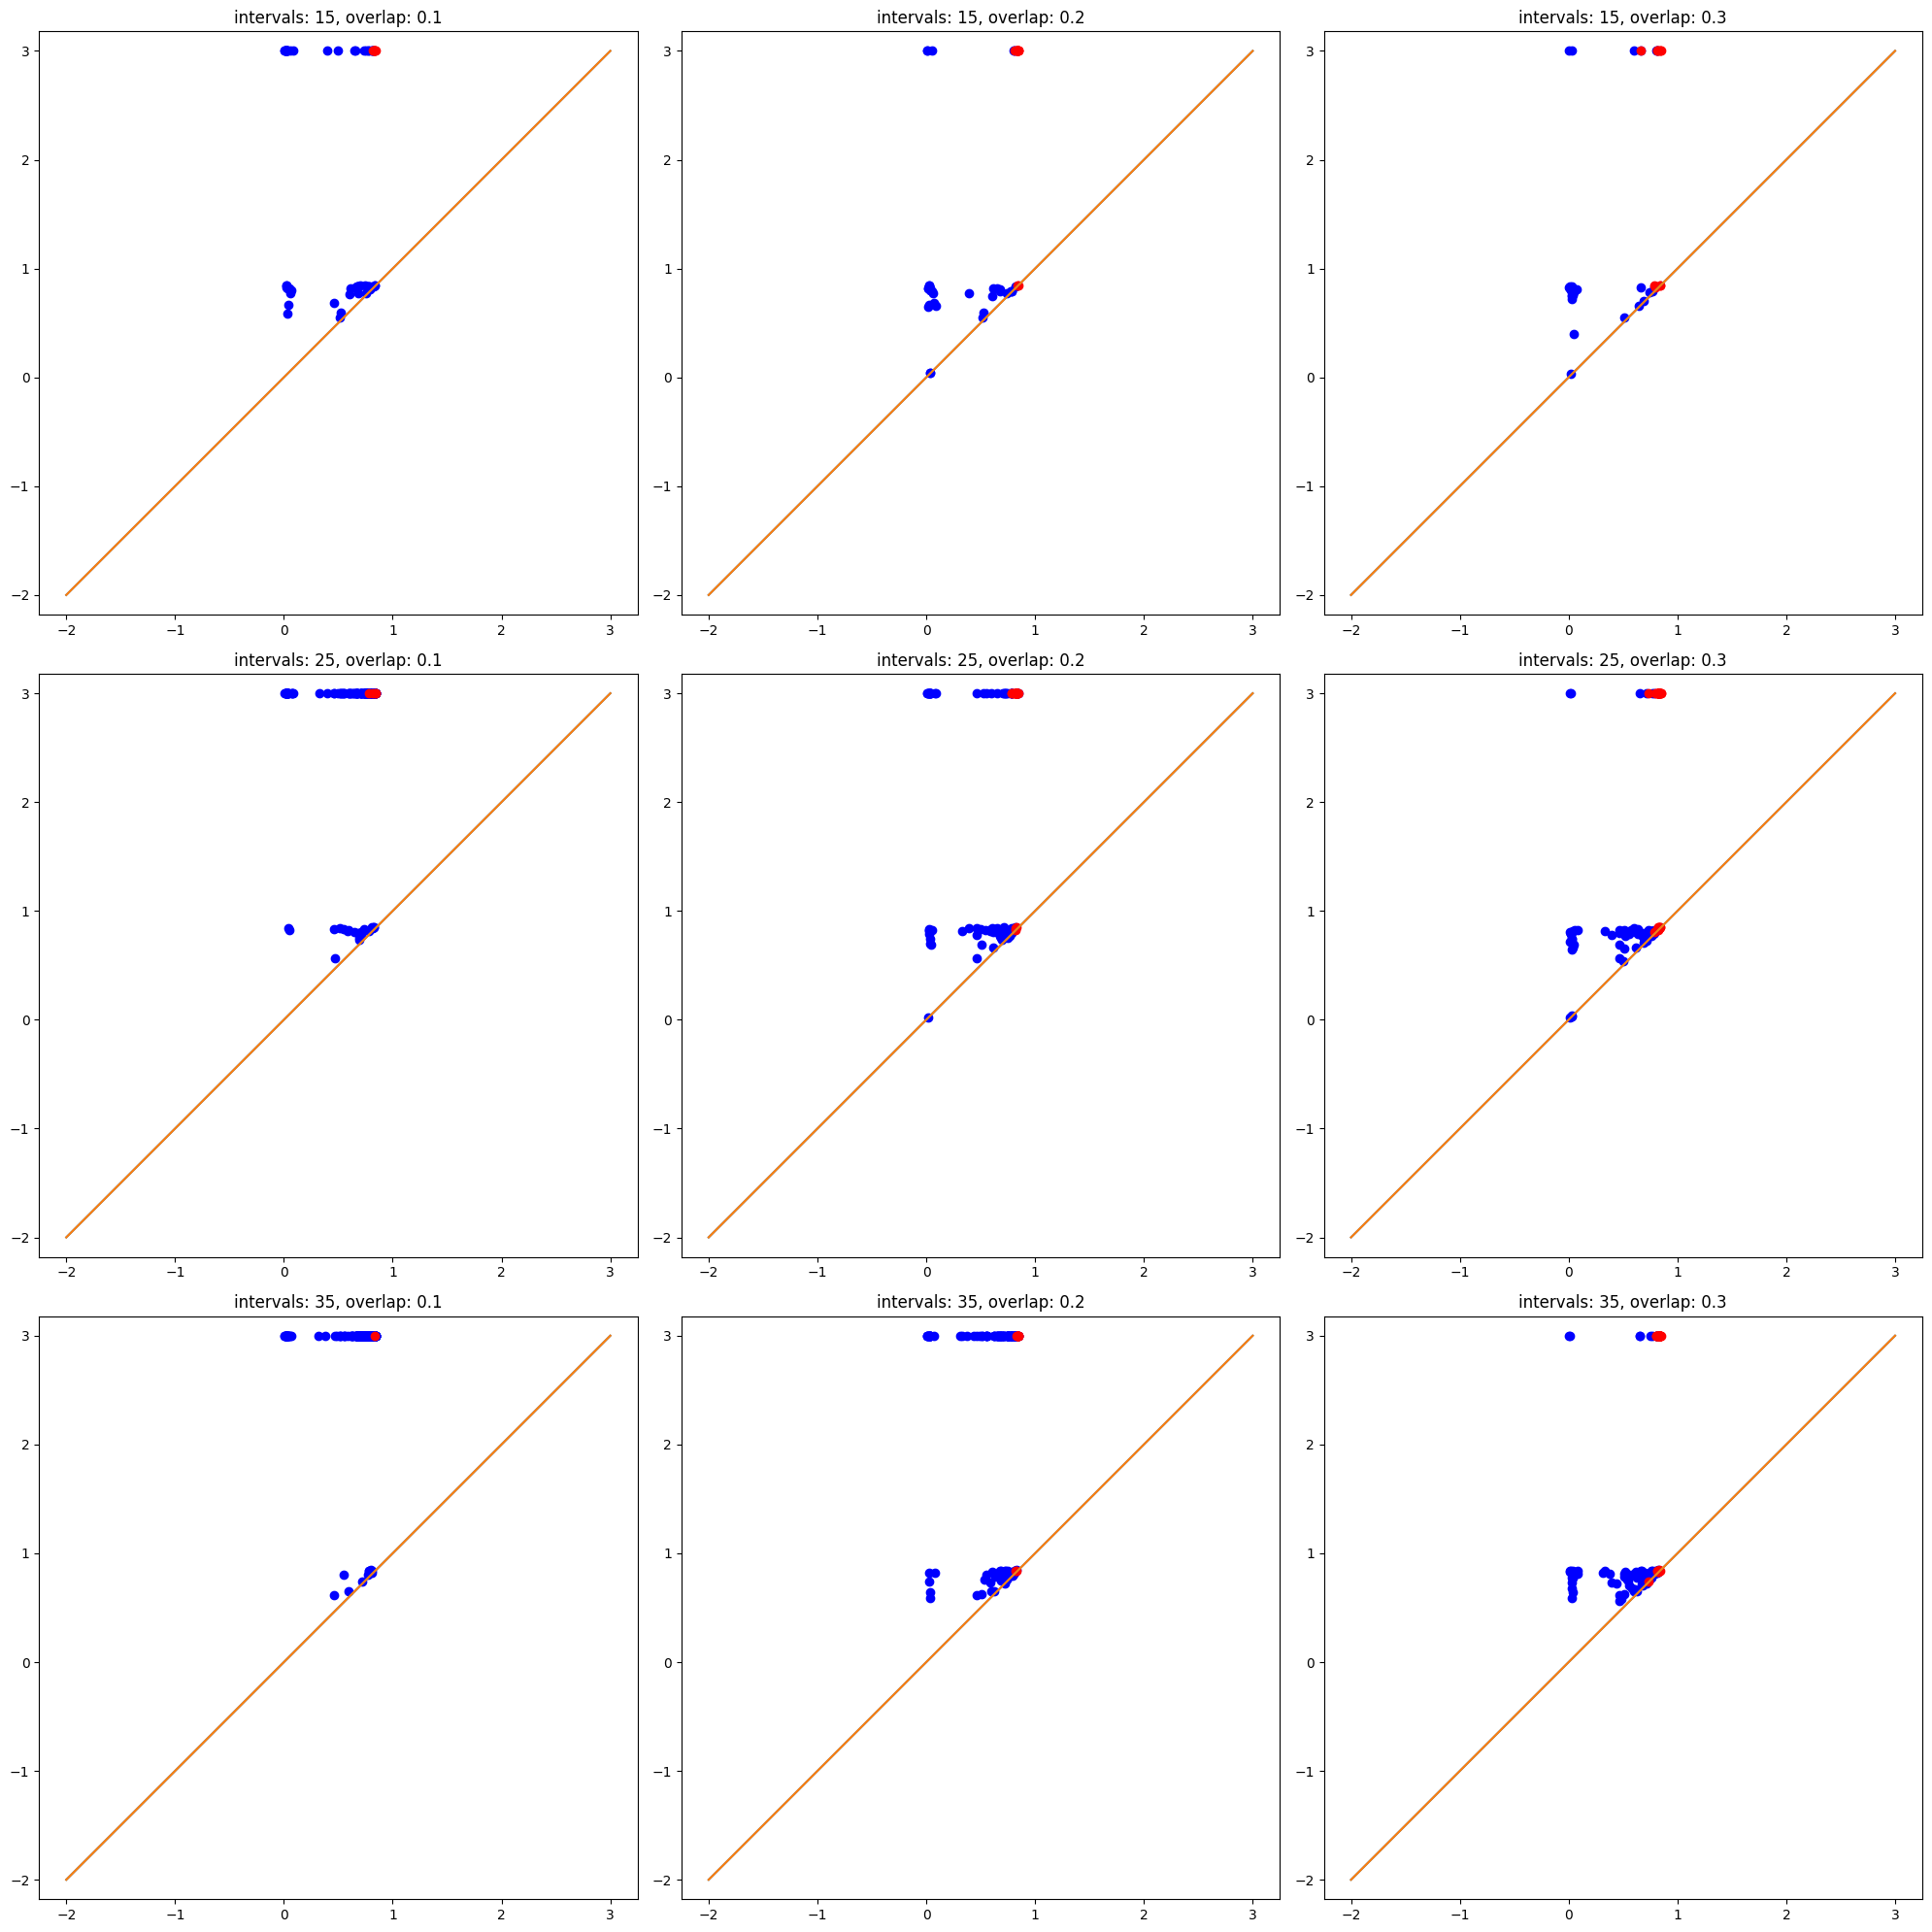

In [188]:
fig, ax = plt.subplots(3,3)
fig.set_size_inches(20,20)

interval_bar = tqdm([15, 25, 35])

for ax_i, n_intervals in enumerate(interval_bar):
    for ax_j, overlap_frac in enumerate([0.1,0.2,0.3]):
        interval_bar.set_description(f"overlap_frac: {overlap_frac}")

        cover = CubicalCover(n_intervals=n_intervals, overlap_frac=overlap_frac, algorithm="standard")
        clust = DBSCAN(eps=5)
        graph = MapperAlgorithm(cover, clust).fit_transform(X, X)

        simplices = []
        for c in networkx.enumerate_all_cliques(graph):
            simplices.append((c, np.max([1-y[i] for i in c])))

        f = d.Filtration()
        for vertices, time in simplices:
            f.append(d.Simplex(vertices, time))
        f.sort()
        p = d.cohomology_persistence(f, prime=47)
        dgms = d.init_diagrams(p, f)
        d.plot.plot_all_diagrams(dgms, ax=ax[ax_i, ax_j], pt_style={"c":"g"})
        ax[ax_i, ax_j].set_title(f"intervals: {n_intervals}, overlap: {overlap_frac}")
plt.tight_layout()

  0%|          | 0/3 [00:00<?, ?it/s]

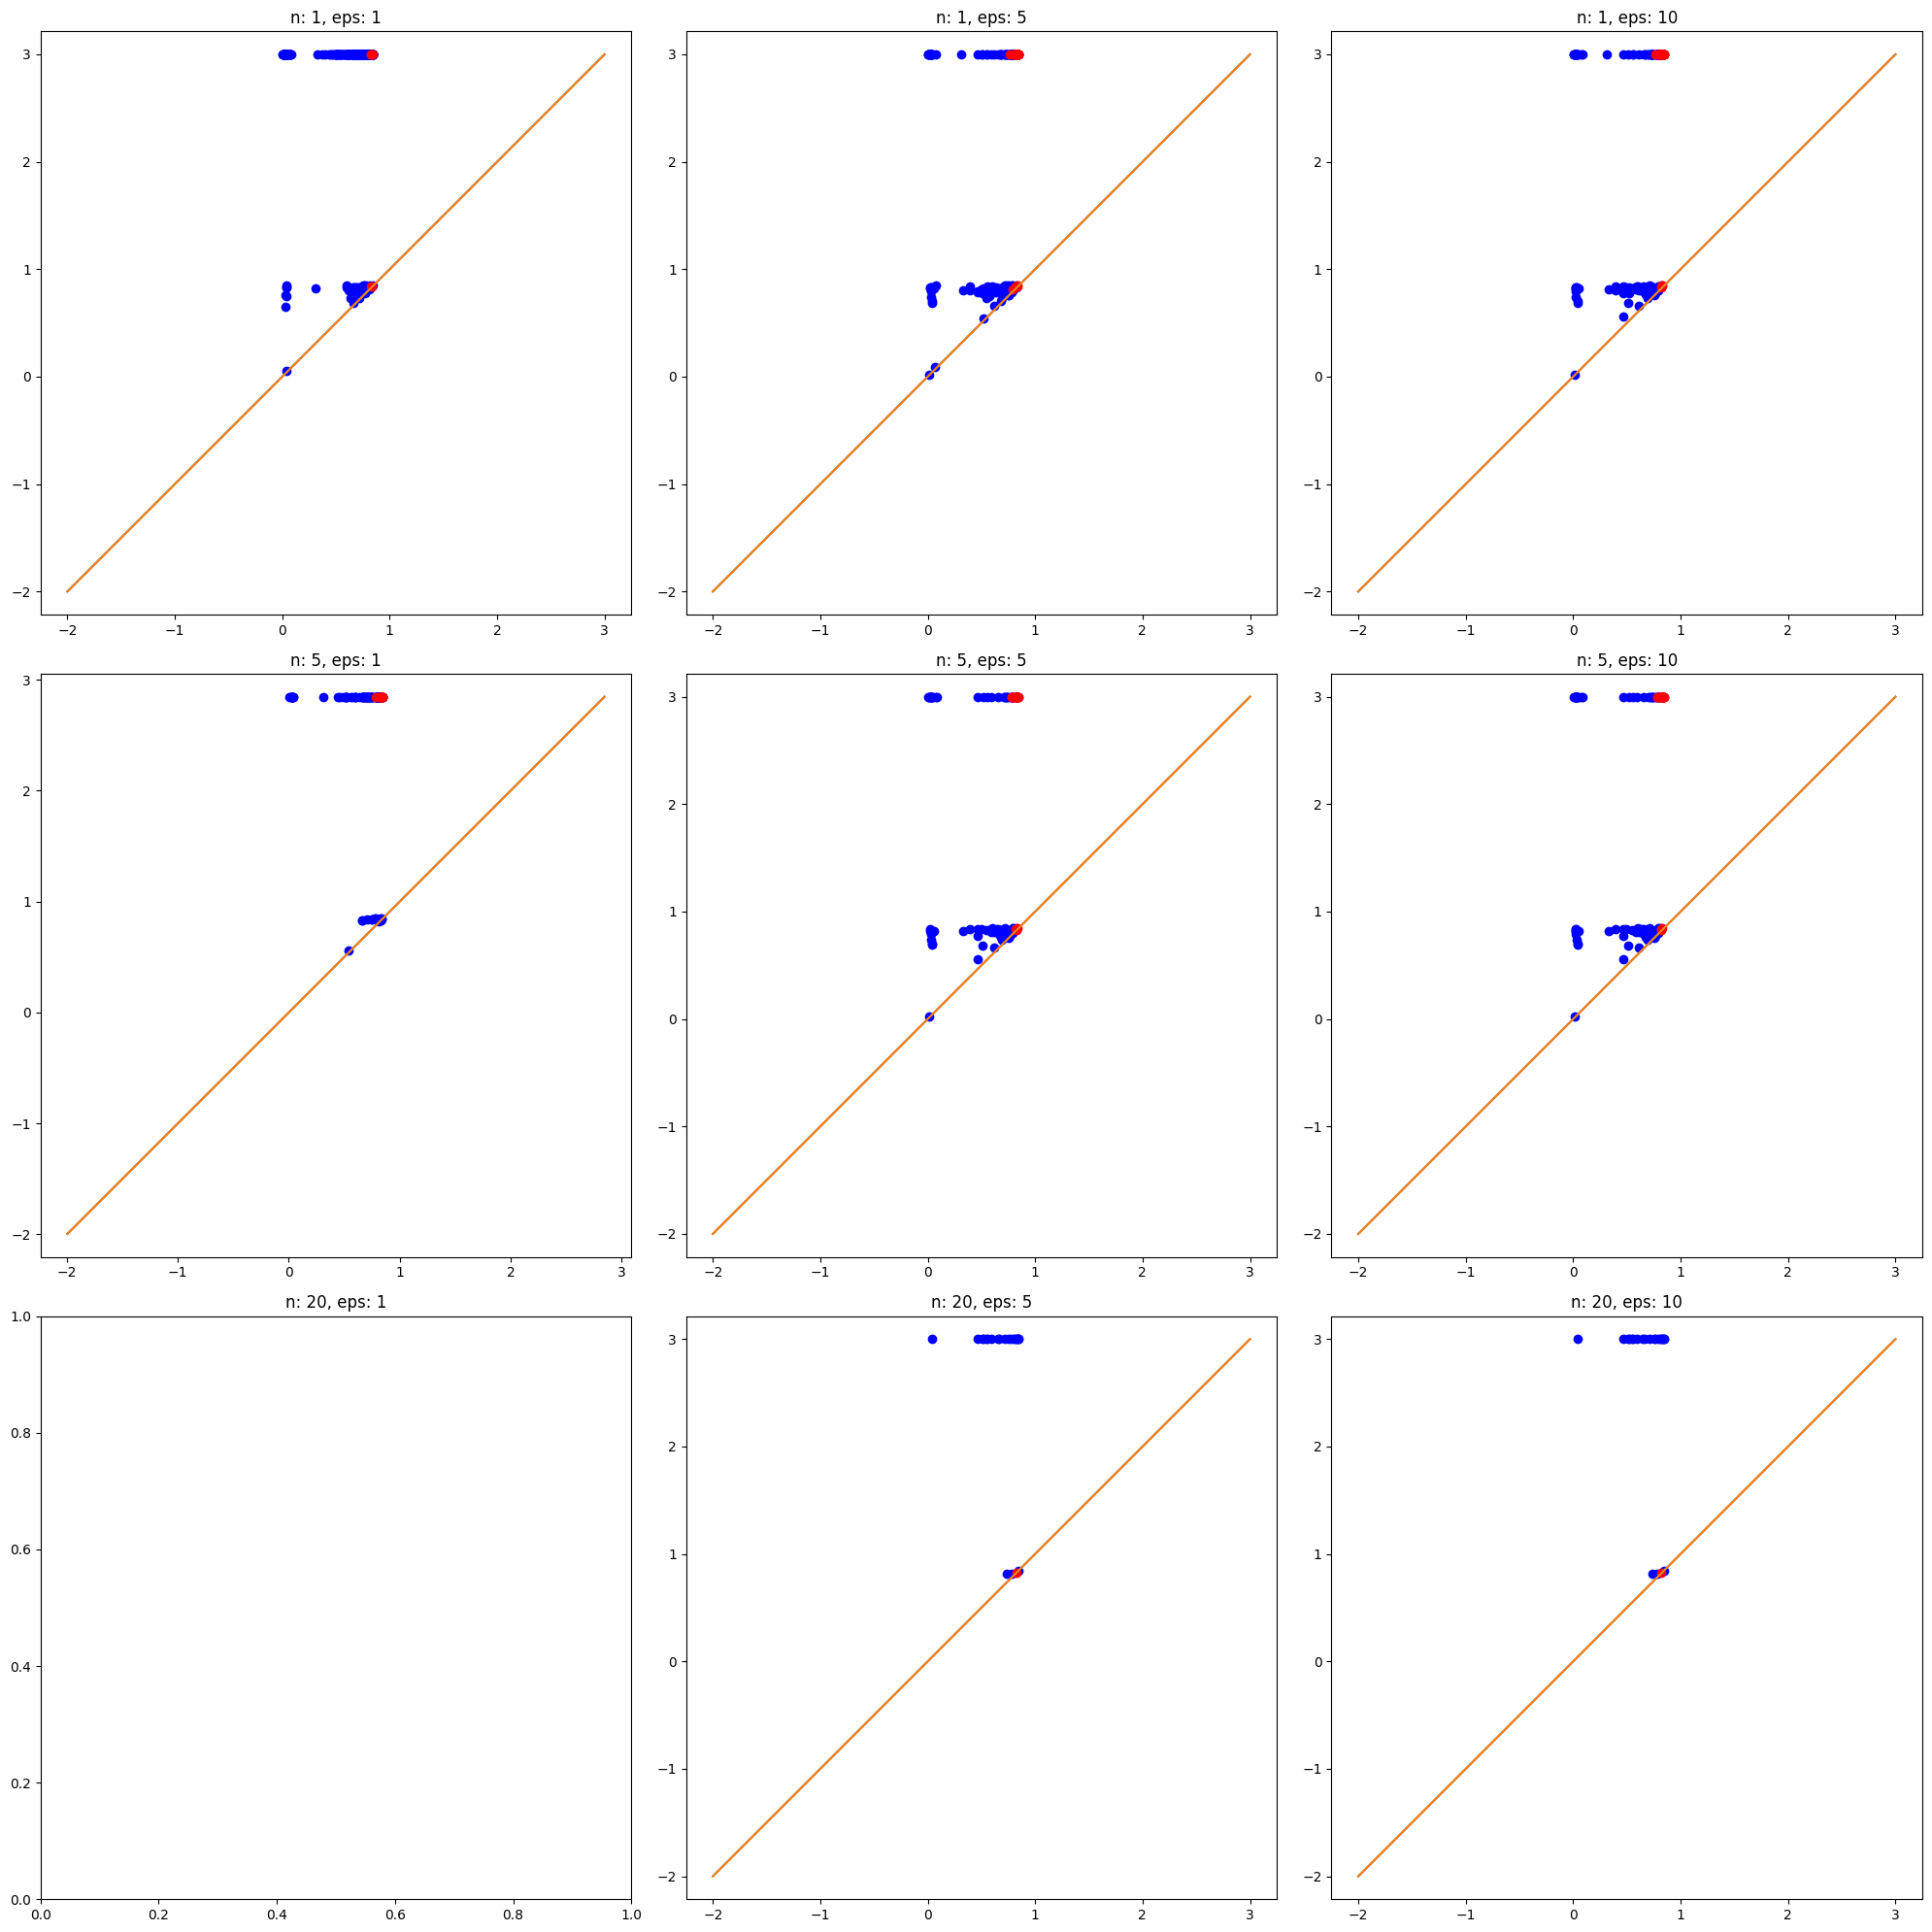

In [189]:
fig, ax = plt.subplots(3,3)
fig.set_size_inches(20,20)

samples_bar = tqdm([1, 5, 20])

for ax_i, dbscan_min_samples in enumerate(samples_bar):
    for ax_j, dbscan_eps in enumerate([1,5,10]):
        samples_bar.set_description(f"dbscan_eps: {dbscan_eps}")

        cover = CubicalCover(n_intervals=25, overlap_frac=0.2, algorithm="standard")
        clust = DBSCAN(eps=dbscan_eps, min_samples = dbscan_min_samples)
        graph = MapperAlgorithm(cover, clust).fit_transform(X, X)

        simplices = []
        for c in networkx.enumerate_all_cliques(graph):
            simplices.append((c, np.max([1-y[i] for i in c])))

        f = d.Filtration()
        for vertices, time in simplices:
            f.append(d.Simplex(vertices, time))
        f.sort()
        p = d.cohomology_persistence(f, prime=47)
        dgms = d.init_diagrams(p, f)
        d.plot.plot_all_diagrams(dgms, ax=ax[ax_i, ax_j])
        # try:
        #     d.plot.plot_diagram(dgms[0], ax=ax[ax_i, ax_j], pt_style={"c":"b"})
        # except:
        #     print(f"Didn't work for n: {dbscan_min_samples}, eps: {dbscan_eps}")
        #     continue
        # d.plot.plot_diagram(dgms[1], ax=ax[ax_i, ax_j], pt_style={"c":"r"})
        # d.plot.plot_diagram(dgms[2], ax=ax[ax_i, ax_j], pt_style={"c":"g"})
        ax[ax_i, ax_j].set_title(f"n: {dbscan_min_samples}, eps: {dbscan_eps}")
plt.tight_layout()

  0%|          | 0/5 [00:00<?, ?it/s]

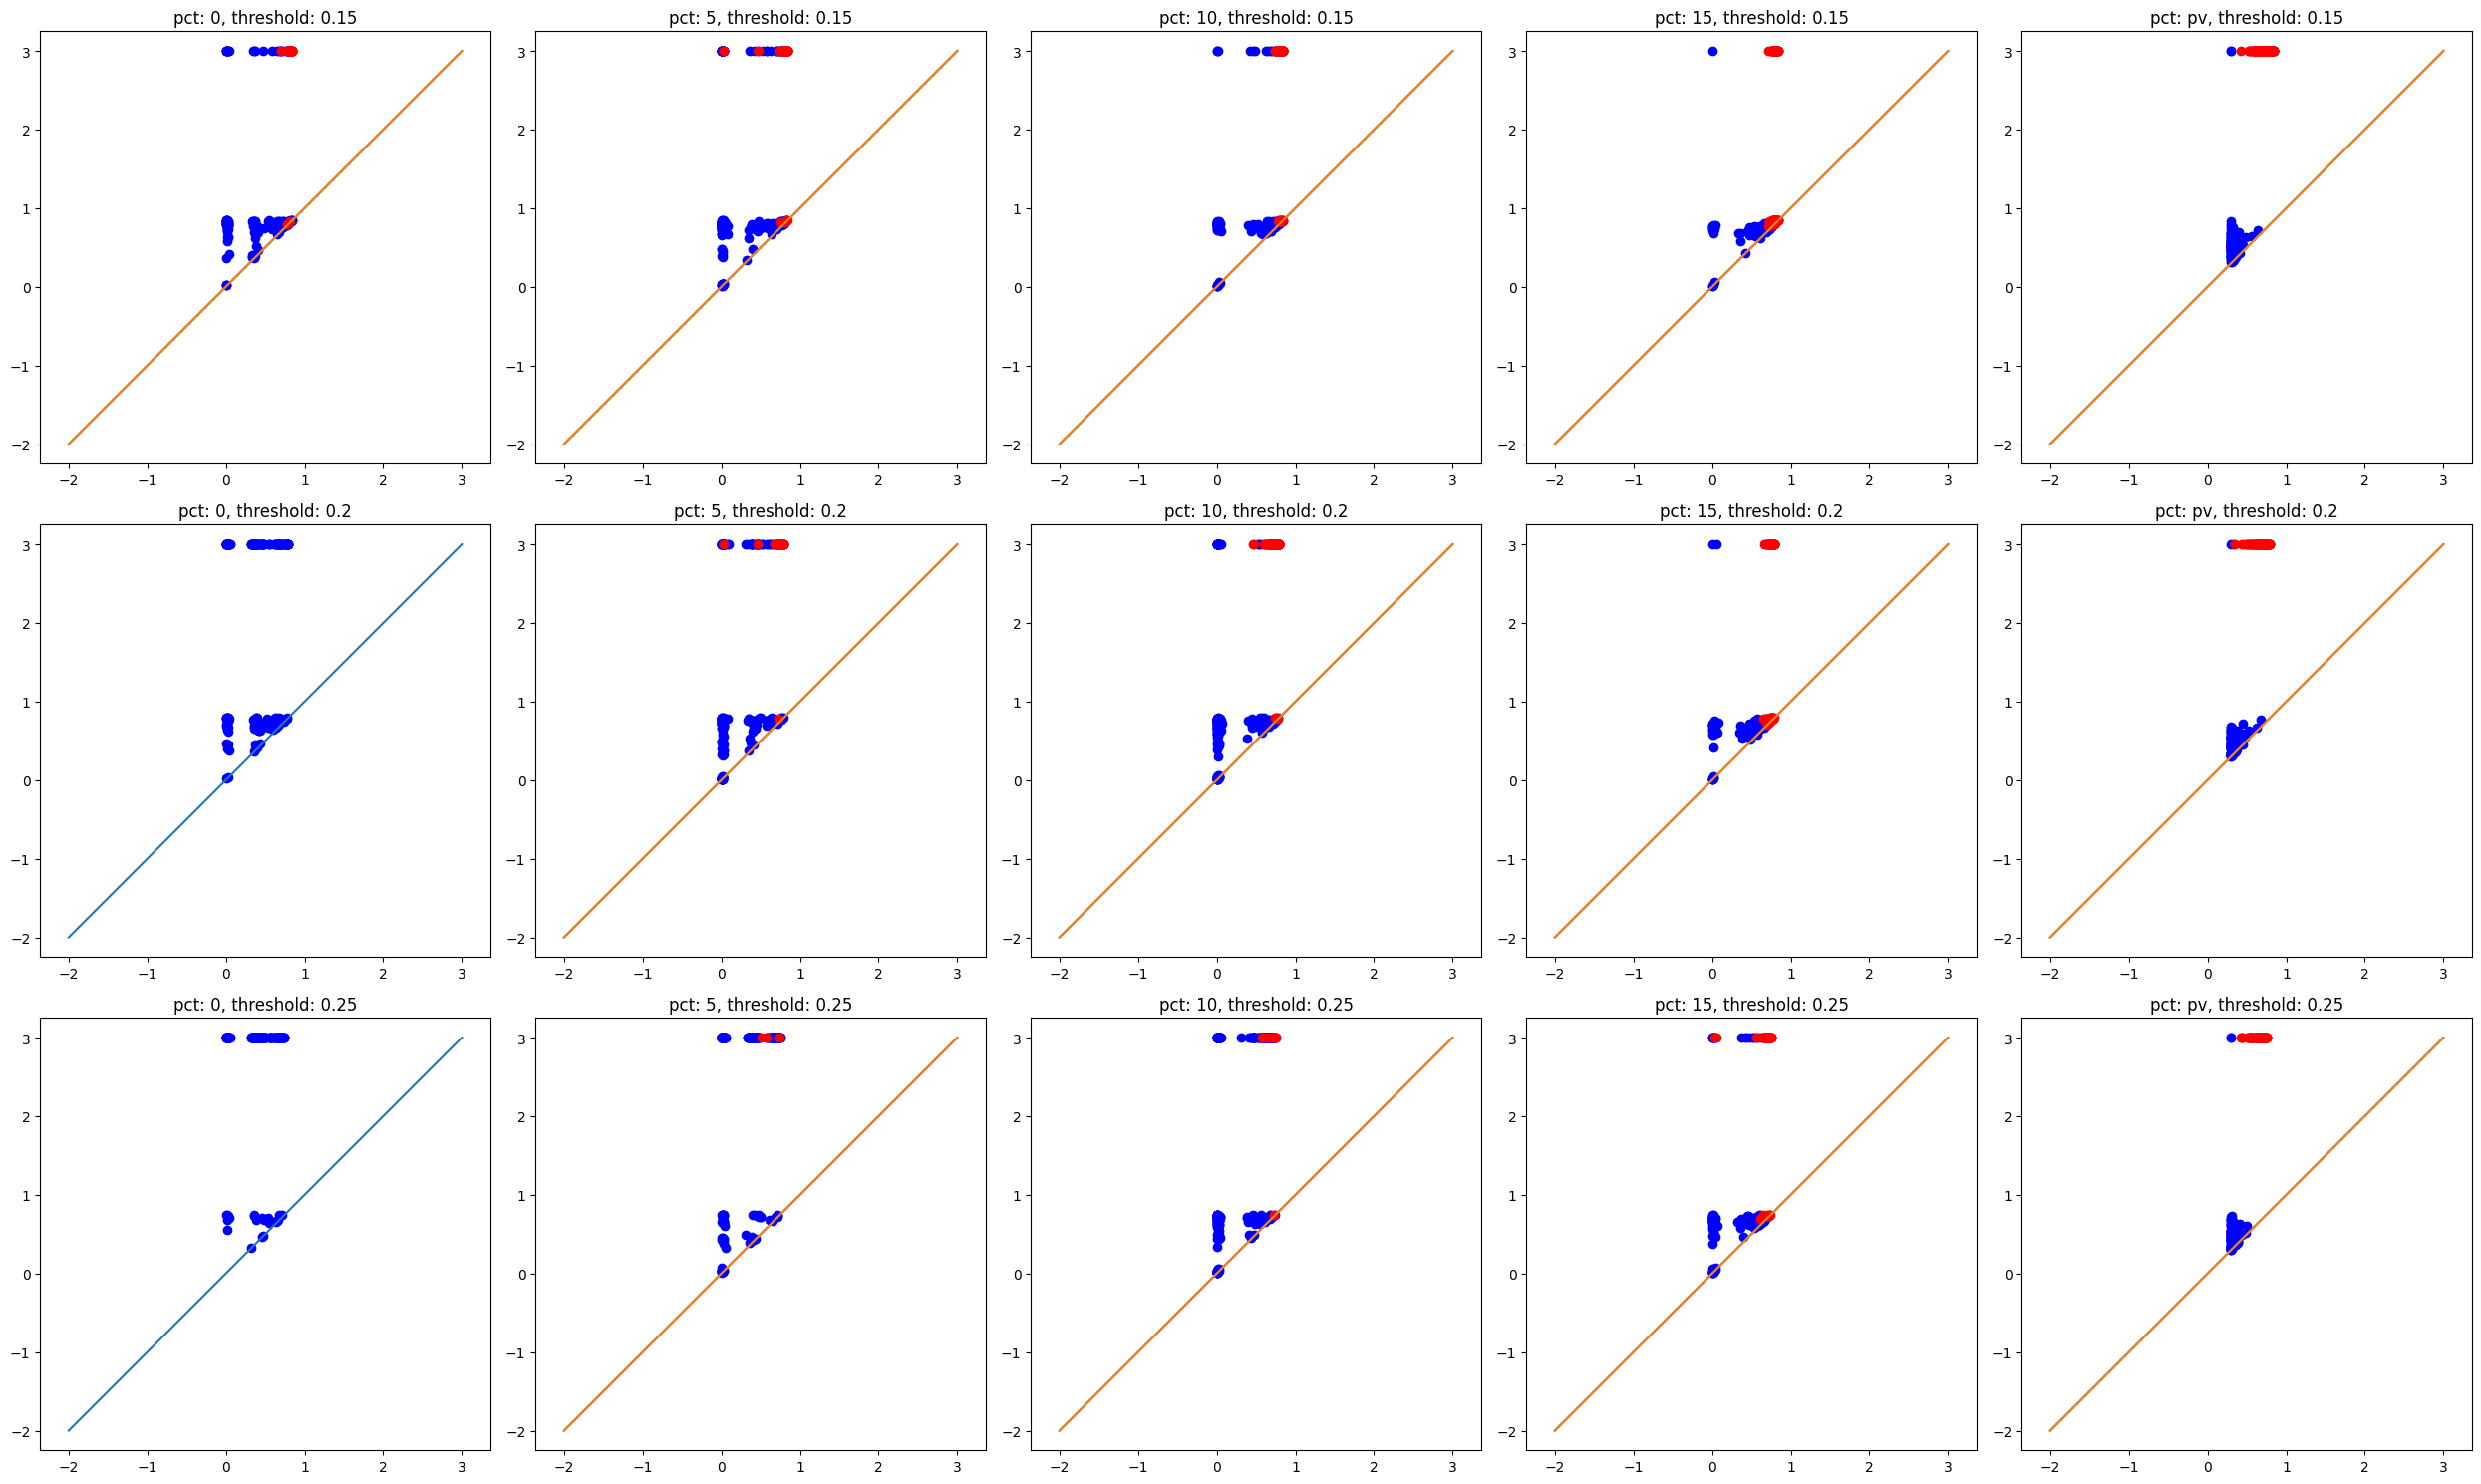

In [192]:
fig, ax = plt.subplots(3,5)
fig.set_size_inches(25,15)

pct_bar = tqdm(["0", "5", "10", "15", "pv"])


for ax_j, pct in enumerate(pct_bar):
    for ax_i, threshold in enumerate([0.15,0.2,0.25]):
        if pct != "pv":
            im_gray = 1-np.array(Image.open(f"../figures/GND{pct}pct_rotated.jpg").convert("L")).astype(int)/255
        else:
            im_gray = 1-np.array(Image.open(f"../figures/tot10_0_2d.png").convert("L")).astype(int)/255

        X = np.vstack(np.where(im_gray>threshold)).T
        y = [im_gray[X[i,0], X[i,1]] for i in range(X.shape[0])]

        pct_bar.set_description(f"threshold: {threshold}")

        cover = CubicalCover(n_intervals=25, overlap_frac=0.2, algorithm="standard")
        clust = DBSCAN(eps=5)
        graph = MapperAlgorithm(cover, clust).fit_transform(X, X)

        simplices = []
        for c in networkx.enumerate_all_cliques(graph):
            simplices.append((c, np.max([1-y[i] for i in c])))

        f = d.Filtration()
        for vertices, time in simplices:
            f.append(d.Simplex(vertices, time))
        f.sort()
        p = d.cohomology_persistence(f, prime=47)
        dgms = d.init_diagrams(p, f)
        d.plot.plot_all_diagrams(dgms, ax=ax[ax_i, ax_j])
        ax[ax_i, ax_j].set_title(f"pct: {pct}, threshold: {threshold}")
plt.tight_layout()

  0%|          | 0/4 [00:00<?, ?it/s]

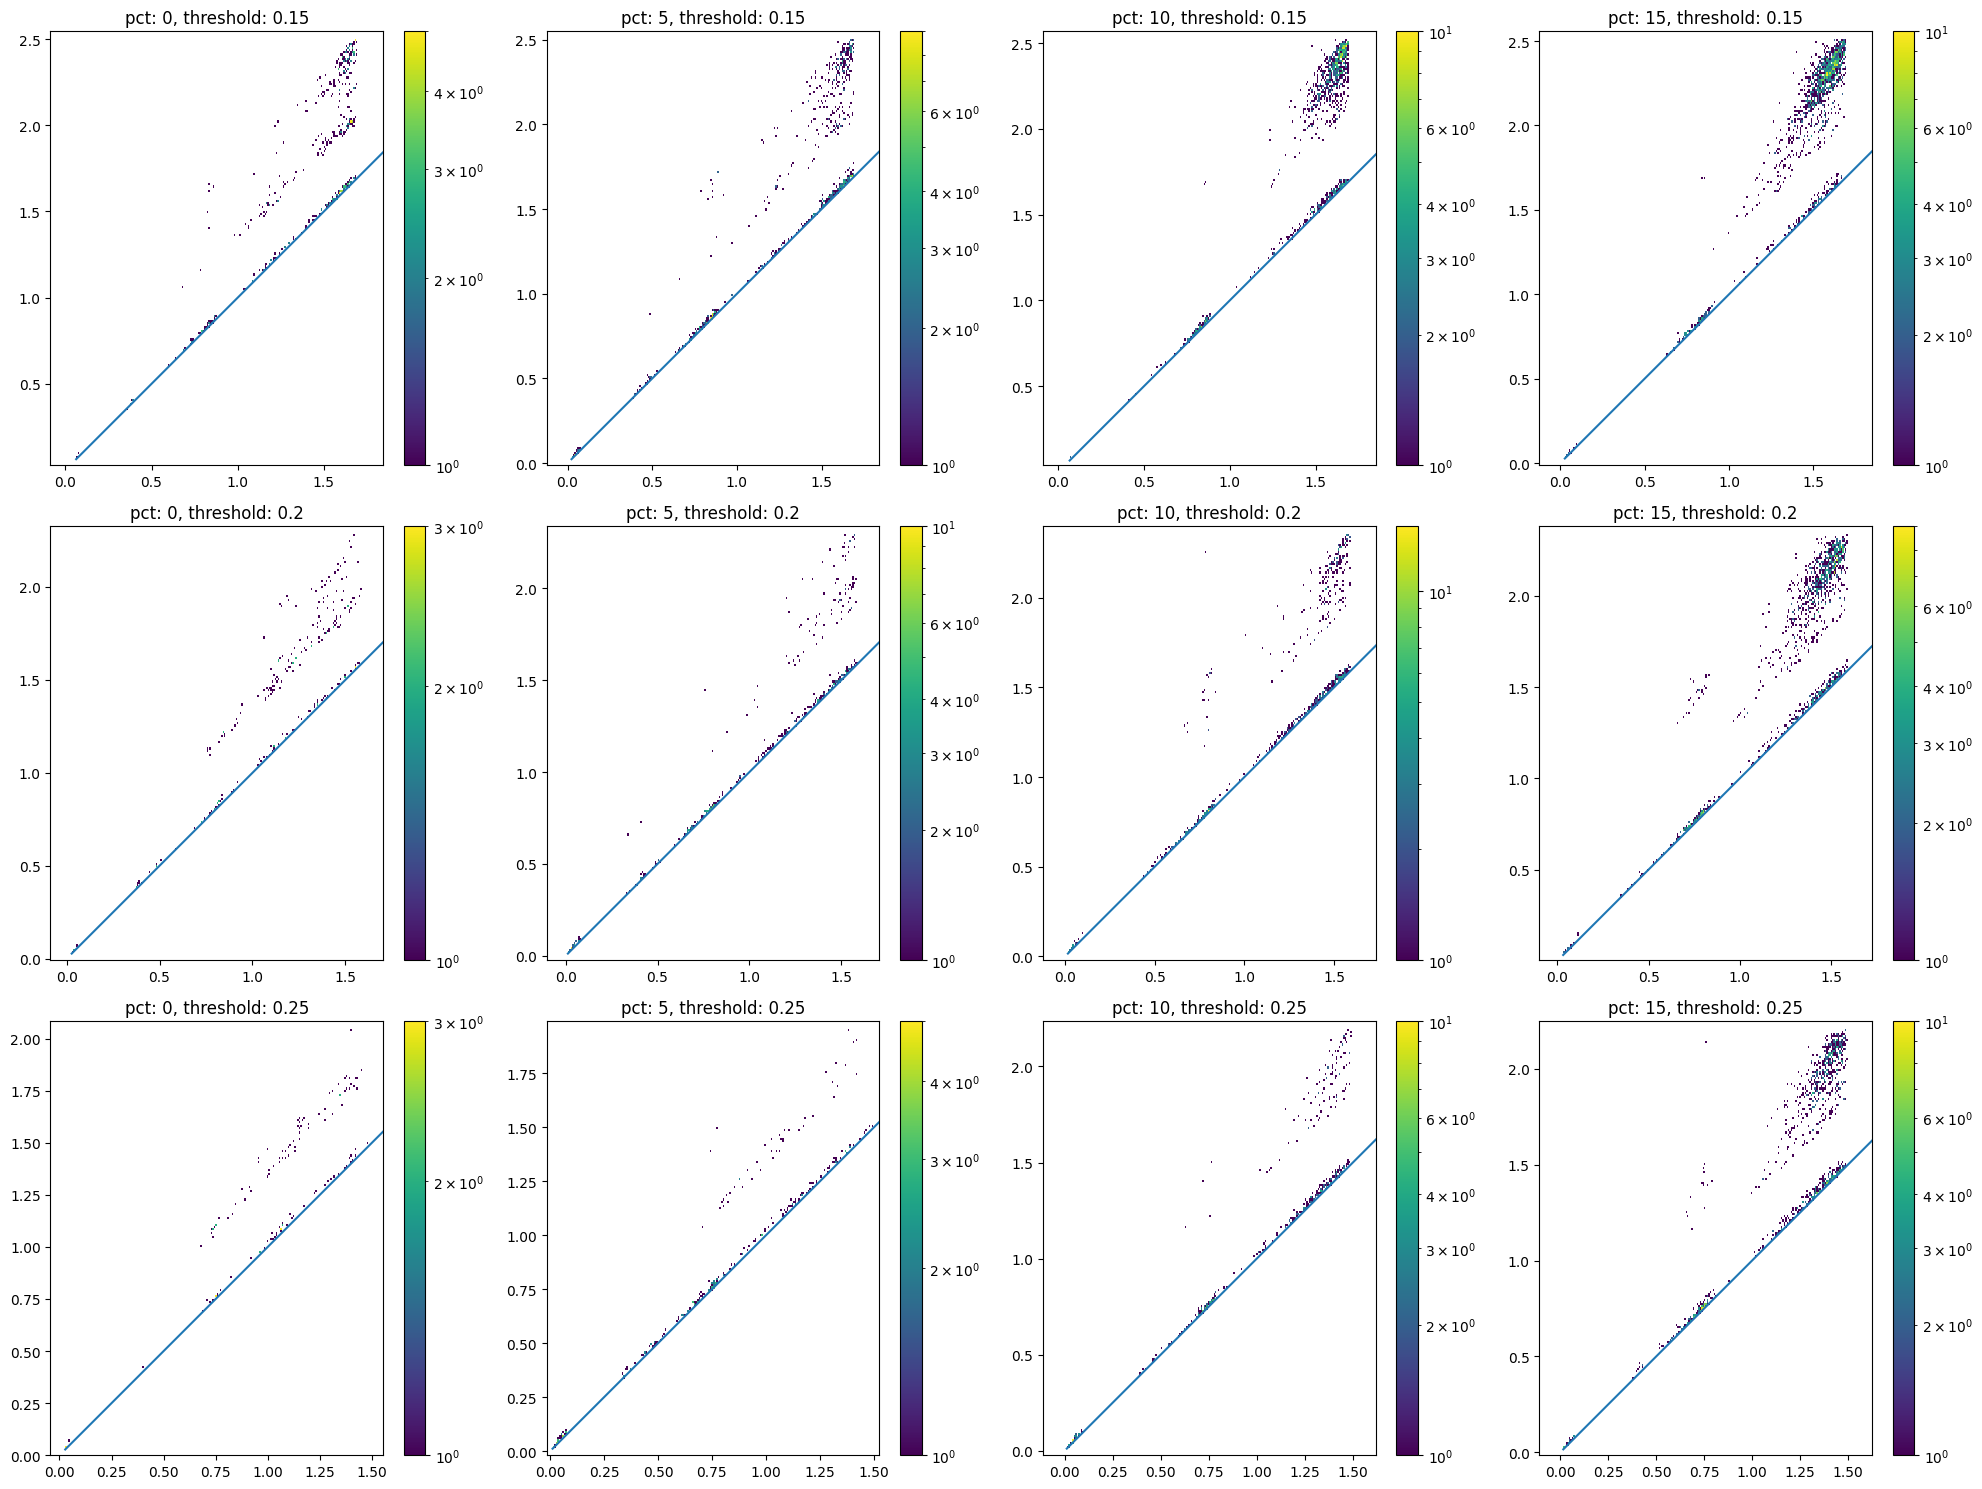

In [60]:
fig, ax = plt.subplots(3,4)
fig.set_size_inches(20,15)

pct_bar = tqdm(["0", "5", "10", "15"])


for ax_j, pct in enumerate(pct_bar):
    for ax_i, threshold in enumerate([0.15,0.2,0.25]):
        im_gray = 1-np.array(Image.open(f"../figures/GND{pct}pct_rotated.jpg").convert("L")).astype(int)/255

        X = np.vstack(np.where(im_gray>threshold)).T
        y = [im_gray[X[i,0], X[i,1]] for i in range(X.shape[0])]

        pct_bar.set_description(f"threshold: {threshold}")

        cover = CubicalCover(n_intervals=25, overlap_frac=0.2, algorithm="standard")
        clust = DBSCAN(eps=5)
        graph = MapperAlgorithm(cover, clust).fit_transform(X, X)

        simplices = []
        for c in networkx.enumerate_all_cliques(graph):
            simplices.append((c, np.sum([1-y[i] for i in c])))

        f = d.Filtration()
        for vertices, time in simplices:
            f.append(d.Simplex(vertices, time))
        f.sort()
        p = d.cohomology_persistence(f, prime=47)
        dgms = d.init_diagrams(p, f)
        # d.plot.plot_diagram_density(dgms[0], ax=ax[ax_i, ax_j])
        d.plot.plot_diagram_density(dgms[1], ax=ax[ax_i, ax_j])
        # d.plot.plot_diagram_density(dgms[2], ax=ax[ax_i, ax_j])
        ax[ax_i, ax_j].set_title(f"pct: {pct}, threshold: {threshold}")
plt.tight_layout()

In [30]:
node_info = {"node_id": [], "neighbors": [], "KAM": []}
for node in graph.nodes:
    
    node_info["node_id"].append(str(node))
    node_info["neighbors"].append([i for i in graph.neighbors(node)])
    node_info["KAM"].append(np.mean(np.array([y[i] for i in graph.nodes[node]["ids"]])))
    
node_df = pd.DataFrame(node_info).set_index("node_id").sort_values(by="KAM", ascending=False)

edge_info = {"edge_id": [], "KAM": []}
for edge in graph.edges:
    edge = [str(i) for i in edge]
    edge_info["edge_id"].append(",".join(edge))
    edge_info["KAM"].append(np.sum([node_df.loc[edge[0]]["KAM"], node_df.loc[edge[1]]["KAM"]]))

edge_df = pd.DataFrame(edge_info).set_index("edge_id").sort_values(by="KAM", ascending=False)

Cohomology persistence of 3753 cells

In [110]:
cluster_means = []
for i_cluster, cluster in enumerate(cover.apply(X)):
    m = np.mean([X[i] for i in cluster], axis=0)
    cluster_means.append(m)
cluster_means = np.array(cluster_means)

In [112]:
cluster_means.shape

(562, 2)

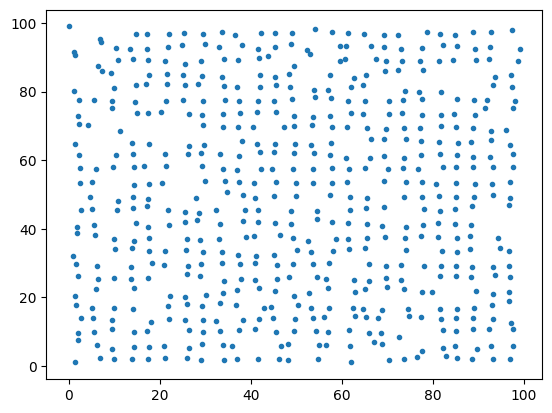

In [113]:
plt.scatter(cluster_means[:, 0], cluster_means[:, 1], marker=".")